In [110]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torchsummary import summary
import numpy as np
from torch import nn, optim
import os, os.path
from PIL import Image
import matplotlib.pyplot as plt

In [111]:
classes = ['Potato Early blight','Potato healthy', 'Potato Late blight']

In [112]:
class MyData(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Iterate through class folders
        for class_label, class_name in enumerate(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                # Iterate through image files
                for image_name in os.listdir(class_dir):
                    image_path = os.path.join(class_dir, image_name)
                    # Add to samples list as (image_path, class_label) tuple
                    self.samples.append((image_path, class_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, class_label = self.samples[idx]

        # Load image and apply transformation if provided
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, class_label

In [113]:
dataset = MyData('PlantVillage', transform=transforms.ToTensor())

trainset, testset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.75), int(len(dataset)*0.25)])
testset, valset = torch.utils.data.random_split(testset, [int(len(testset)*0.5), int(len(testset)*0.5)])

In [114]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=16, shuffle=True)
valloader = DataLoader(valset, batch_size=16, shuffle=True)
print('Lenght of trainloader: ', len(trainloader),
      '\nLenght of testloader: ', len(testloader),
        '\nLenght of valloader: ', len(valloader))

Lenght of trainloader:  26 
Lenght of testloader:  17 
Lenght of valloader:  17


torch.Size([64, 3, 256, 256])


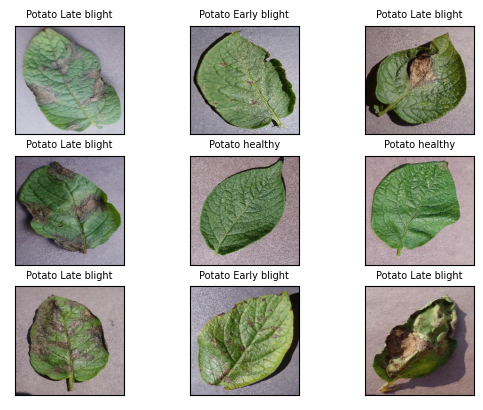

In [115]:
for images, labels in trainloader:
    show_im, show_lab = images, labels
    break

plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1, xticks=[], yticks=[])
    image = np.transpose(show_im[i], (1,2,0))
    plt.title(classes[show_lab[i].item()], fontsize= 7)
    plt.imshow(image)
print(show_im.shape)

In [161]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(256*256*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 256*256*3)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

In [162]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [163]:
fnn_model = FNN()
print(fnn_model)

FNN(
  (fc1): Linear(in_features=196608, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)


In [158]:
fnn_optimizer = optim.Adam(fnn_model.parameters(), lr=0.001)
fnn_criterion = nn.CrossEntropyLoss()

In [164]:
epochs = 5
train_losses, valid_losses = [], []

for e in range(epochs):
    running_loss = 0
    val_loss = 0
    for i, data in enumerate(trainloader):
        fnn_model.train()
        images, labels = data
        #images, labels = images.to(device), labels.to(device)
        
        fnn_optimizer.zero_grad()
        
        outs = fnn_model(images)
        loss = fnn_criterion(outs, labels)
        loss.backward()
        fnn_optimizer.step()
        running_loss += loss.item()
    with torch.no_grad():
        fnn_model.eval()
        for j, valdata in enumerate(valloader):
            images, labels = valdata
            #images, labels = images.to(device), labels.to(device)
            outs = fnn_model(images)
            loss = fnn_criterion(outs, labels)
            val_loss += loss.item()
        print(f"Epoch: {e+1}/{epochs}.. "
        f"Training Loss: {running_loss/len(trainloader):.3f}.. "
        f"Validation Loss: {val_loss/len(valloader):.3f}.. ")
        train_losses.append(running_loss/len(trainloader))
        valid_losses.append(val_loss/len(valloader))
        running_loss = 0
        val_loss = 0
    
        

Epoch: 1/5.. Training Loss: 1.084.. Validation Loss: 1.084.. 
Epoch: 2/5.. Training Loss: 1.084.. Validation Loss: 1.084.. 
Epoch: 3/5.. Training Loss: 1.084.. Validation Loss: 1.083.. 
Epoch: 4/5.. Training Loss: 1.085.. Validation Loss: 1.084.. 
Epoch: 5/5.. Training Loss: 1.086.. Validation Loss: 1.083.. 


In [170]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    #images, labels = images.to(device), labels.to(device)
    outputs = fnn_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {100 * correct // total} %')

Accuracy on test images: 41 %


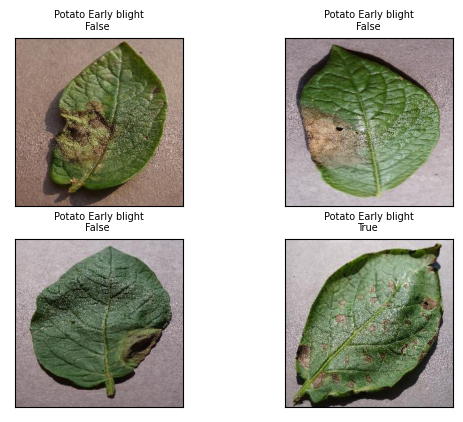

In [168]:
for images, labels in testloader:
    show_im = images
    class_labels = [classes[i] for i in labels]
    fnn_model.eval()
    outputs = fnn_model(images)
    predicted_classes = [classes[i] for i in torch.argmax(outputs, dim=1)]
    break

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1, xticks=[], yticks=[])
    image = np.transpose(show_im[i], (1,2,0))
    plt.title(f'{predicted_classes[i]}\n{class_labels[i] == predicted_classes[i]} ', fontsize= 7)
    plt.imshow(image)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(64)
        )
        self.fc1 = nn.Linear(64*32*32, 512)
        self.fc2 = nn.Linear(512, len(classes))
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN()
model.to(device)
summary(model, torch.zeros((1, 3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 16, 256, 256]        1,216
|    └─ReLU: 2-2                         [-1, 16, 256, 256]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 128, 128]        --
|    └─BatchNorm2d: 2-4                  [-1, 16, 128, 128]        32
├─Sequential: 1-2                        [-1, 32, 64, 64]          --
|    └─Conv2d: 2-5                       [-1, 32, 128, 128]        12,832
|    └─ReLU: 2-6                         [-1, 32, 128, 128]        --
|    └─MaxPool2d: 2-7                    [-1, 32, 64, 64]          --
|    └─BatchNorm2d: 2-8                  [-1, 32, 64, 64]          64
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-9                       [-1, 64, 64, 64]          51,264
|    └─ReLU: 2-10                        [-1, 64, 64, 64]          --
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 16, 256, 256]        1,216
|    └─ReLU: 2-2                         [-1, 16, 256, 256]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 128, 128]        --
|    └─BatchNorm2d: 2-4                  [-1, 16, 128, 128]        32
├─Sequential: 1-2                        [-1, 32, 64, 64]          --
|    └─Conv2d: 2-5                       [-1, 32, 128, 128]        12,832
|    └─ReLU: 2-6                         [-1, 32, 128, 128]        --
|    └─MaxPool2d: 2-7                    [-1, 32, 64, 64]          --
|    └─BatchNorm2d: 2-8                  [-1, 32, 64, 64]          64
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-9                       [-1, 64, 64, 64]          51,264
|    └─ReLU: 2-10                        [-1, 64, 64, 64]          --
|   

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epochs = 5
train_losses, valid_losses = [], []

for e in range(epochs):
    running_loss = 0
    val_loss = 0
    for i, data in enumerate(trainloader):
        model.train()
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outs = model(images)
        loss = loss_function(outs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    with torch.no_grad():
        model.eval()
        for j, valdata in enumerate(valloader):
            images, labels = valdata
            images, labels = images.to(device), labels.to(device)
            outs = model(images)
            loss = loss_function(outs, labels)
            val_loss += loss.item()
        print(f"Epoch: {e+1}/{epochs}.. "
        f"Training Loss: {running_loss/len(trainloader):.3f}.. "
        f"Validation Loss: {val_loss/len(valloader):.3f}.. ")
        train_losses.append(running_loss/len(trainloader))
        valid_losses.append(val_loss/len(valloader))
        running_loss = 0
        val_loss = 0
    
        

Epoch: 1/5.. Training Loss: 0.335.. Validation Loss: 7.721.. 
Epoch: 2/5.. Training Loss: 0.057.. Validation Loss: 3.152.. 
Epoch: 3/5.. Training Loss: 0.017.. Validation Loss: 0.386.. 
Epoch: 4/5.. Training Loss: 0.008.. Validation Loss: 0.113.. 
Epoch: 5/5.. Training Loss: 0.008.. Validation Loss: 0.162.. 


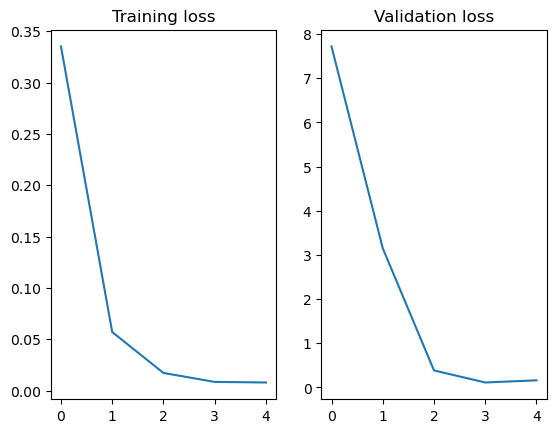

In [ ]:
losses = [train_losses, valid_losses]
titles = ['Training loss', 'Validation loss']
plt.figure()
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    plt.plot(losses[i])

In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {100 * correct // total} %')

Accuracy on test images: 97 %


In [ ]:
torch.save(model.state_dict(), 'model.pth')

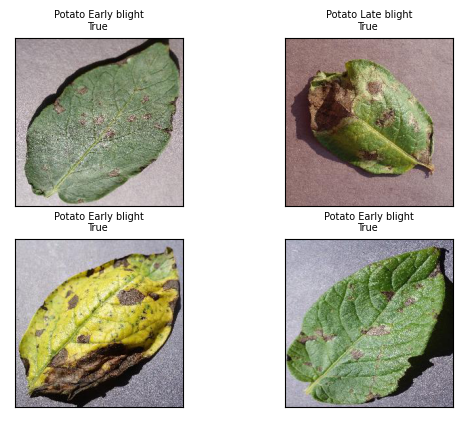

In [ ]:
for images, labels in testloader:
    show_im = images
    class_labels = [classes[i] for i in labels]
    model.eval()
    outputs = model(images.to(device))
    predicted_classes = [classes[i] for i in torch.argmax(outputs, dim=1)]
    break

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1, xticks=[], yticks=[])
    image = np.transpose(show_im[i], (1,2,0))
    plt.title(f'{predicted_classes[i]}\n{class_labels[i] == predicted_classes[i]} ', fontsize= 7)
    plt.imshow(image)